In [1]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install dcor dtaidistance diffprivlib

     |████████████████████████████████| 327kB 9.3MB/s 
     |████████████████████████████████| 92kB 8.9MB/s 
  Created wheel for dtaidistance: filename=dtaidistance-1.2.3-cp36-cp36m-linux_x86_64.whl size=631111 sha256=a3789c7e73100a709bd4ba94e10920715bbf06a8f2833f0f6758b910e08fbaa5
  Stored in directory: /root/.cache/pip/wheels/9f/9a/74/42c5b9dc714bb5a70b426df08cc860e6a741bc199004873e1b
Successfully built dtaidistance


In [0]:
import os
import h5py
import time
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import dcor
from dtaidistance import dtw
from diffprivlib.mechanisms import Laplace

In [0]:
data_dir = 'mitdb'
all_name = 'all_ecg.hdf5'

class ECG(Dataset):
    def __init__(self, mode='all'):
        if mode == 'all':
            with h5py.File(os.path.join(root_path, data_dir, all_name), 'r') as hdf:
                self.x = hdf['x'][:]
                self.x = np.array(random.choices(self.x, k=10000))
        else:
            raise ValueError('Argument of mode should be train, test, or all.')
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.float)

In [0]:
random.seed(2019)
batch_size = 32
dataset = ECG(mode='all')
dataloader = DataLoader(dataset, batch_size=batch_size)

In [0]:
class AvgDownSampler(nn.Module):
    def __init__(self):
        super(AvgDownSampler, self).__init__()
        self.pool = nn.AvgPool1d(4)

    def forward(self, x):
        x = self.pool(x)
        return x.data.numpy().squeeze()

In [0]:
avg_sampler = AvgDownSampler()

In [0]:
min_diff = 1e-5
epsilon = 7

class EcgConv2(nn.Module):
    def __init__(self):
        super(EcgConv2, self).__init__()        
        self.conv1 = nn.Conv1d(1, 16, 7, padding=3)  # 128 x 16
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool1d(2)  # 64 x 16
        self.conv2 = nn.Conv1d(16, 16, 5, padding=2)  # 64 x 16
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool1d(2)  # 32 x 16
        self.linear3 = nn.Linear(32 * 16, 128)
        self.relu3 = nn.LeakyReLU()
        self.linear4 = nn.Linear(128, 5)
        self.softmax4 = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # differential privacy
        x_data = x.data.numpy()
        bound = np.dstack((np.max(x_data, axis=0), np.min(x_data, axis=0)))
        for i in range(bound.shape[0]):
            for j in range(bound.shape[1]):
                interval = bound[i][j]
                if interval[0] - interval[1] < min_diff:
                    interval[0] += min_diff * 0.5
                    interval[1] -= min_diff * 0.5
        for j in range(x_data.shape[1]):
            for k in range(x_data.shape[2]):
                dp = Laplace()
                dp = dp.set_epsilon(epsilon)
                dp = dp.set_sensitivity(bound[j][k][0] - bound[j][k][1])
                for i in range(x_data.shape[0]):
                    x_data[i][j][k] = dp.randomise(x_data[i][j][k])

        return x_data

In [9]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

ecg_conv2 = EcgConv2()
ecg_conv2.load_state_dict(torch.load(os.path.join(root_path, 'model', 'conv2_best_ep7.pth'), map_location=torch.device('cpu')))
ecg_conv2.eval()

EcgConv2(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear3): Linear(in_features=512, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (linear4): Linear(in_features=128, out_features=5, bias=True)
  (softmax4): Softmax(dim=1)
)

In [10]:
dtw_list = [list() for i in range(16)]
dcor_avg_sample = [list() for i in range(16)]
# dcor_max_sample = [list() for i in range(16)]

for i, x_batch in enumerate(tqdm(dataloader)):
    output = ecg_conv2(x_batch)
    for n in range(len(output)):
        x_single = x_batch[0].clone().detach()
        x_single_avgdown = avg_sampler(x_single.unsqueeze(0))
        output_single = output[n]
        for j, o in enumerate(output_single):
            dtw_val = dtw.distance_fast(x_single.data.numpy().squeeze().astype(np.double), o.astype(np.double))
            dtw_list[j].append(dtw_val)
            dcor_val = dcor.distance_correlation(x_single_avgdown, o)
            dcor_avg_sample[j].append(dcor_val)

100%|██████████| 313/313 [04:36<00:00,  1.34it/s]


In [11]:
np.array(dtw_list).shape

(16, 10000)

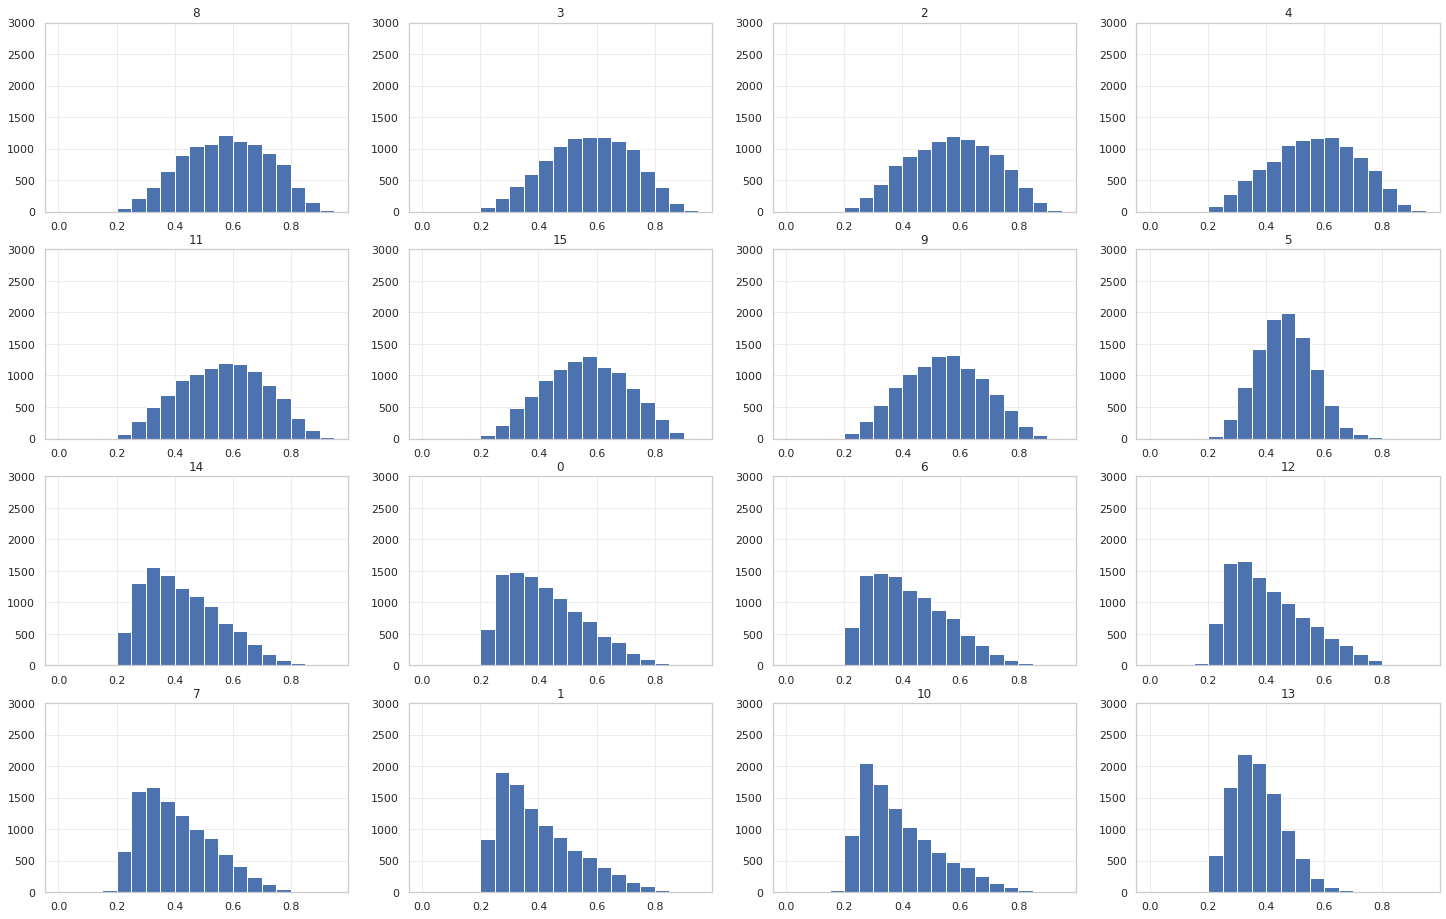

In [12]:
sns.set(style='whitegrid', rc={"grid.linewidth": 0.5, 'grid.linestyle': '--'})
dcor_avg_sample = np.array(dcor_avg_sample)
idx = np.argsort(np.mean(dcor_avg_sample, axis=1))[::-1]
dcor_avg_sample = dcor_avg_sample[idx]
fig, ax = plt.subplots(4, 4, figsize=(25, 16))
for i in range(16):
    a = ax[i//4][i%4]
    a.set_ylim(0, 3000)
    a.set_title(idx[i])
    a.hist(dcor_avg_sample[i], bins=[0.05 * i for i in range(20)])
np.savetxt(os.path.join(root_path, 'dtw_dcor', 'conv2_dcor_diffpriv_ep7.csv'), dcor_avg_sample, delimiter=",", fmt='%.4f')
np.savetxt(os.path.join(root_path, 'dtw_dcor', 'conv2_dcor_mean_diffpriv_ep7.csv'), np.mean(dcor_avg_sample, axis=1), delimiter=",", fmt='%.4f')

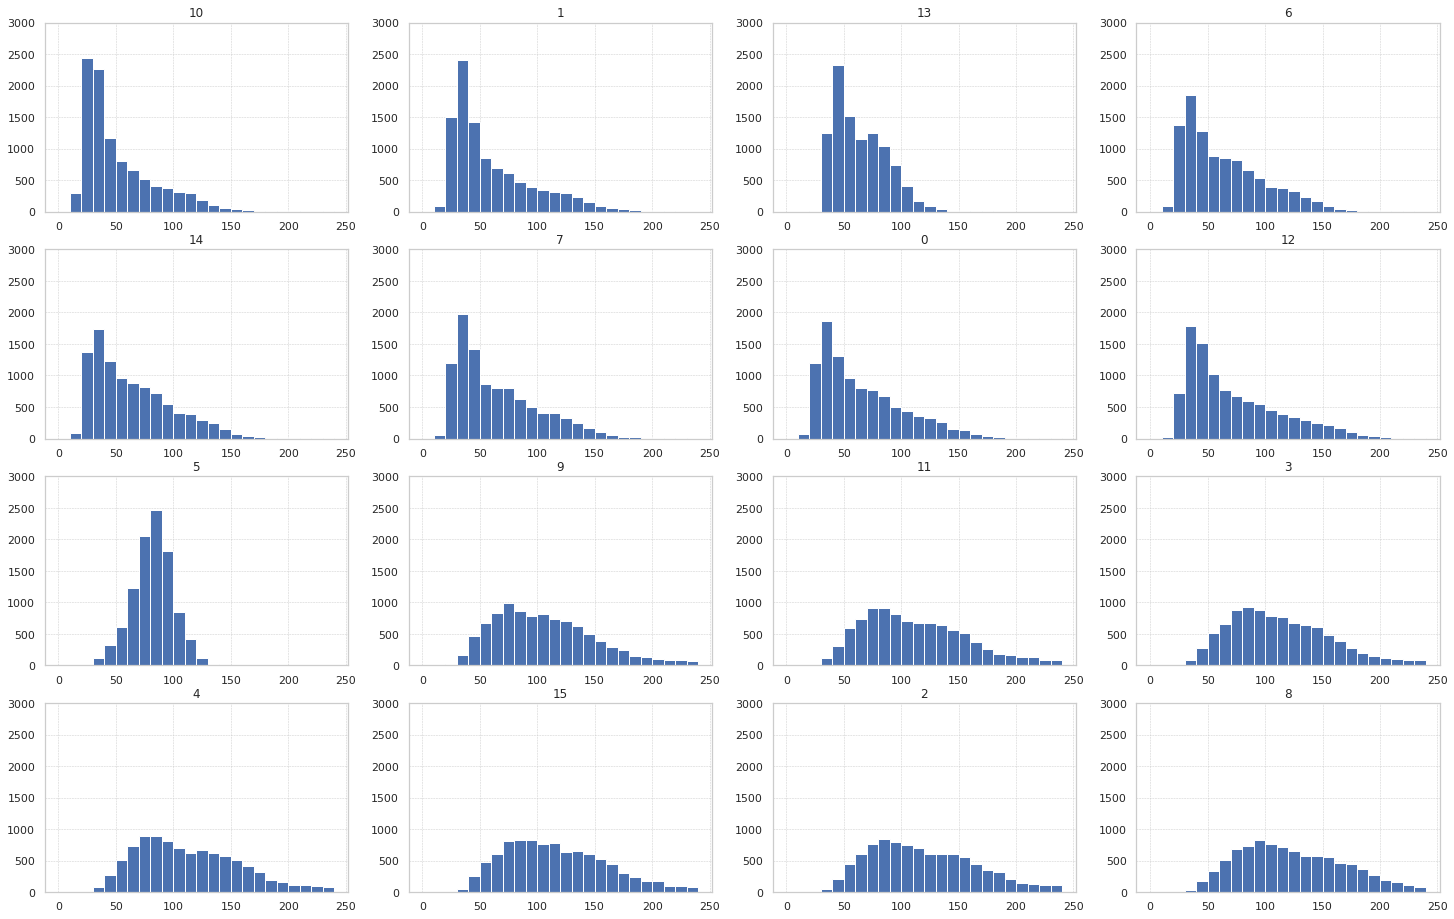

In [13]:
dtw_list = np.array(dtw_list)
idx = np.argsort(np.mean(dtw_list, axis=1))
dtw_list = dtw_list[idx]
fig, ax = plt.subplots(4, 4, figsize=(25, 16))
for i in range(16):
    a = ax[i//4][i%4]
    a.set_ylim(0, 3000)
    a.set_title(idx[i])
    a.hist(dtw_list[i], bins=[10 * i for i in range(25)])
np.savetxt(os.path.join(root_path, 'dtw_dcor', 'conv2_dtw_diffpriv_ep7.csv'), dtw_list, delimiter=",", fmt='%.4f')
np.savetxt(os.path.join(root_path, 'dtw_dcor', 'conv2_dtw_mean_diffpriv_ep7.csv'), np.mean(dtw_list, axis=1), delimiter=",", fmt='%.4f')